# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = './input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

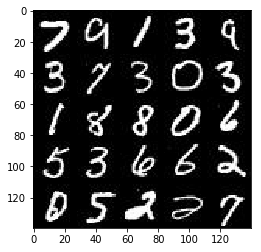

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

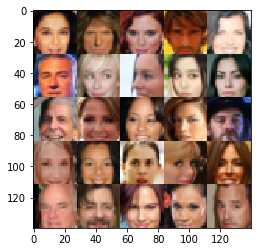

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [46]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), \
                                       name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [82]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):

        alpha = 0.2
        dropout_rate = 0.1
        
        # First conv layer, input 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        drop1 = tf.layers.dropout(x1, rate=dropout_rate)
        relu1 = tf.maximum(alpha * drop1, drop1)
        
        # Second conv layer
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        drop2 = tf.layers.dropout(x2, rate=dropout_rate)
        norm2 = tf.layers.batch_normalization(drop2, training=True)
        relu2 = tf.maximum(alpha * norm2, norm2)

        # Third conv layer
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        drop3 = tf.layers.dropout(x3, rate=dropout_rate)
        norm3 = tf.layers.batch_normalization(drop3, training=True)
        relu3 = tf.maximum(alpha * norm3, norm3)

        # Output layer
        flat = tf.reshape(relu3, (-1, 4*4*512))
        dense = tf.layers.dense(flat, 1024) #, activation=tf.nn.relu)
        dropout = tf.layers.dropout(dense, rate=dropout_rate)
        logits = tf.layers.dense(dropout, 1)
        output = tf.sigmoid(logits)

    
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [83]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        dropout_rate = 0.1

        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        drop1 = tf.layers.dropout(x1, rate=dropout_rate)
        shape1 = tf.reshape(drop1, (-1, 7, 7, 512))
        norm1 = tf.layers.batch_normalization(shape1, training=is_train)
        relu1 = tf.maximum(alpha * norm1, norm1) 
        
        # Second conv layer
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        norm2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * norm2, norm2)
        
        # Third conv layer
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        norm3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * norm3, norm3)
    
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        output = tf.tanh(logits)

    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [49]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
  
    smooth = 0.1
    
    # Generator model
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator models
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
                                    logits=d_logits_real, \
                                    labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
                                    logits=d_logits_fake, \
                                    labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
                                    logits=d_logits_fake, \
                                    labels=tf.ones_like(d_model_fake)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [50]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, \
                                         beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, \
                                         beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [84]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    _, image_width, image_height, out_channel_dim = data_shape
    
    # Build Model    
    input_real, input_z, lr = model_inputs(image_width, image_height, out_channel_dim, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # batch images
                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    n_images = 49
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                                
       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 7.5326... Generator Loss: 189.5937
Epoch 1/2... Discriminator Loss: 8.2997... Generator Loss: 151.2044
Epoch 1/2... Discriminator Loss: 26.8598... Generator Loss: 9.4700
Epoch 1/2... Discriminator Loss: 67.4977... Generator Loss: 0.0000
Epoch 1/2... Discriminator Loss: 9.9110... Generator Loss: 2.8266
Epoch 1/2... Discriminator Loss: 4.7536... Generator Loss: 6.2171
Epoch 1/2... Discriminator Loss: 1.8277... Generator Loss: 6.8159
Epoch 1/2... Discriminator Loss: 3.7672... Generator Loss: 0.2311
Epoch 1/2... Discriminator Loss: 4.8689... Generator Loss: 9.9000
Epoch 1/2... Discriminator Loss: 5.1721... Generator Loss: 7.5303


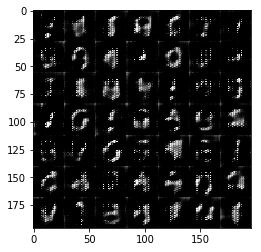

Epoch 1/2... Discriminator Loss: 2.3740... Generator Loss: 0.5290
Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 2.4630
Epoch 1/2... Discriminator Loss: 0.9810... Generator Loss: 2.0790
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.8771
Epoch 1/2... Discriminator Loss: 2.0515... Generator Loss: 0.4011
Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 1.1288
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.7307
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 2.3983
Epoch 1/2... Discriminator Loss: 0.8521... Generator Loss: 1.4732
Epoch 1/2... Discriminator Loss: 1.4715... Generator Loss: 2.9631


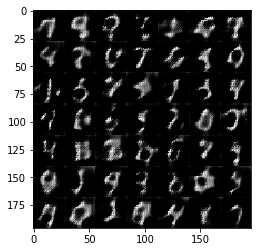

Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 1.9089
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 1.8115
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 1.7257
Epoch 1/2... Discriminator Loss: 0.8916... Generator Loss: 1.7024
Epoch 1/2... Discriminator Loss: 1.6416... Generator Loss: 0.3784
Epoch 1/2... Discriminator Loss: 1.2671... Generator Loss: 1.7401
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.1892
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 2.0927
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 1.2921
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 1.4714


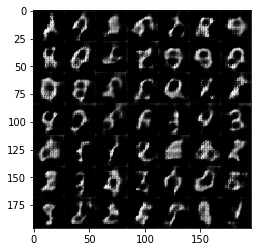

Epoch 1/2... Discriminator Loss: 1.0557... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 0.9266
Epoch 1/2... Discriminator Loss: 1.0657... Generator Loss: 1.0941
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 1.2409
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 0.9947
Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 1.0871
Epoch 1/2... Discriminator Loss: 1.4655... Generator Loss: 0.4705


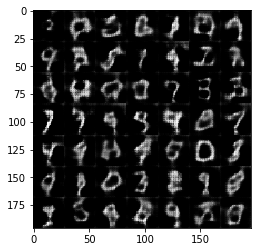

Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 1.0632
Epoch 1/2... Discriminator Loss: 1.1765... Generator Loss: 1.1777
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 1.0643
Epoch 1/2... Discriminator Loss: 1.2930... Generator Loss: 0.5567
Epoch 1/2... Discriminator Loss: 1.9909... Generator Loss: 3.0578
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 1.0902
Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 1.4217
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 1.5600
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 0.9066
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 1.6779


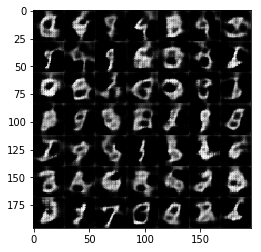

Epoch 1/2... Discriminator Loss: 1.0664... Generator Loss: 1.2133
Epoch 1/2... Discriminator Loss: 1.0655... Generator Loss: 0.9649
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 1.1586
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.9678
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 1.1478
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 1.0224
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 1.0908
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 0.7438
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.6357
Epoch 1/2... Discriminator Loss: 1.0130... Generator Loss: 1.0990


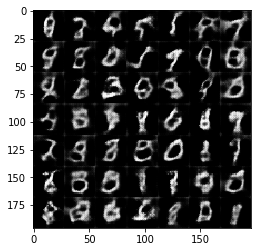

Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 1.1177
Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 1.2522
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 1.4612
Epoch 1/2... Discriminator Loss: 1.1666... Generator Loss: 1.0162
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 0.7919
Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 1.1331
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 1.0551
Epoch 1/2... Discriminator Loss: 1.8576... Generator Loss: 0.2975
Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 0.8747


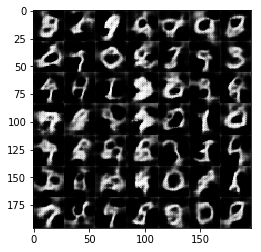

Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 0.9956
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 0.6851
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.1964
Epoch 1/2... Discriminator Loss: 0.9800... Generator Loss: 1.3567
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 0.9329
Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 0.9434
Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 0.9479


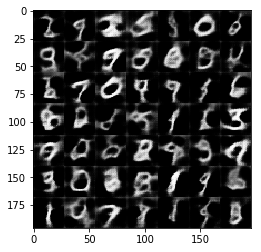

Epoch 1/2... Discriminator Loss: 1.6471... Generator Loss: 0.4058
Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 1.9537
Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 1.1127
Epoch 1/2... Discriminator Loss: 1.8612... Generator Loss: 2.7223
Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 0.9852
Epoch 1/2... Discriminator Loss: 1.0618... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 1.2804... Generator Loss: 1.7183
Epoch 1/2... Discriminator Loss: 1.2931... Generator Loss: 0.5733


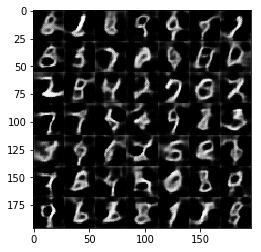

Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 1.0309
Epoch 1/2... Discriminator Loss: 1.0504... Generator Loss: 1.0698
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 1.1566... Generator Loss: 1.0011
Epoch 2/2... Discriminator Loss: 1.1598... Generator Loss: 1.5534
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 1.1134
Epoch 2/2... Discriminator Loss: 1.0084... Generator Loss: 1.2947
Epoch 2/2... Discriminator Loss: 1.9221... Generator Loss: 0.2972
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.5946
Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 1.1741


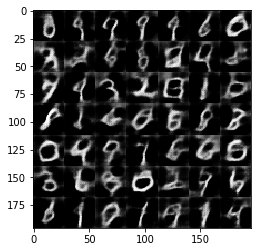

Epoch 2/2... Discriminator Loss: 0.9537... Generator Loss: 1.2083
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.5211
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.7462
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 0.8686
Epoch 2/2... Discriminator Loss: 1.5162... Generator Loss: 2.1838
Epoch 2/2... Discriminator Loss: 1.0075... Generator Loss: 1.1692
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 1.2018
Epoch 2/2... Discriminator Loss: 1.2583... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 1.4046


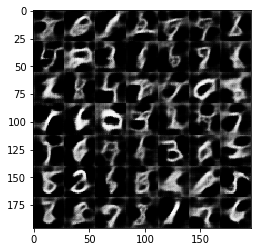

Epoch 2/2... Discriminator Loss: 1.1573... Generator Loss: 1.1193
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 1.2061
Epoch 2/2... Discriminator Loss: 1.6462... Generator Loss: 0.4056
Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 1.2084
Epoch 2/2... Discriminator Loss: 1.1397... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 1.3105
Epoch 2/2... Discriminator Loss: 1.2794... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 0.9275
Epoch 2/2... Discriminator Loss: 1.6265... Generator Loss: 0.4423
Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 1.0128


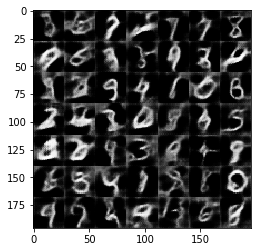

Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 3.0656
Epoch 2/2... Discriminator Loss: 1.5727... Generator Loss: 0.4231
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.7504
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 1.2493
Epoch 2/2... Discriminator Loss: 1.0701... Generator Loss: 1.1082
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 1.6154... Generator Loss: 0.4024
Epoch 2/2... Discriminator Loss: 1.1586... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 1.0145


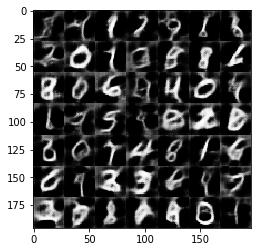

Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.6099
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 0.9197
Epoch 2/2... Discriminator Loss: 1.1096... Generator Loss: 0.9308
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.5905
Epoch 2/2... Discriminator Loss: 1.1614... Generator Loss: 0.7263
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 1.2937
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 1.5089
Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 1.1168


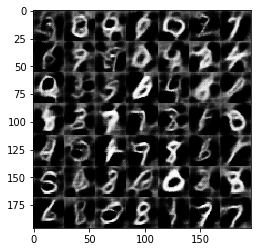

Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 1.1002
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 1.9257
Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 1.2631
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 0.6553
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 1.0727
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 1.1241
Epoch 2/2... Discriminator Loss: 1.9590... Generator Loss: 0.3000
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 1.0658
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.7093
Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 0.8547


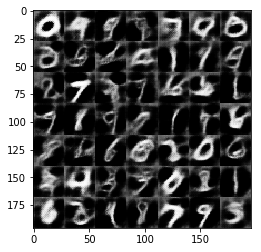

Epoch 2/2... Discriminator Loss: 1.5861... Generator Loss: 2.6627
Epoch 2/2... Discriminator Loss: 1.9476... Generator Loss: 3.1654
Epoch 2/2... Discriminator Loss: 1.1770... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 1.0684... Generator Loss: 0.9088
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 1.9744
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.7982
Epoch 2/2... Discriminator Loss: 1.0543... Generator Loss: 1.0555
Epoch 2/2... Discriminator Loss: 2.5749... Generator Loss: 5.1801
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 0.8735


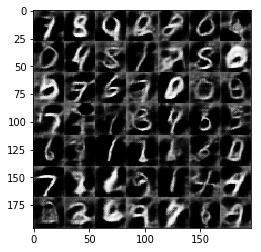

Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.9541
Epoch 2/2... Discriminator Loss: 1.5886... Generator Loss: 0.4281
Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 1.3102
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.7875
Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 1.3023
Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 1.2234
Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 0.9527
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 1.0150
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 1.0209
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 1.2684


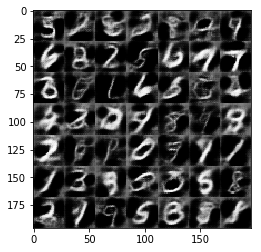

Epoch 2/2... Discriminator Loss: 1.5437... Generator Loss: 2.3165
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.8229
Epoch 2/2... Discriminator Loss: 1.5445... Generator Loss: 2.5119
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 1.1064
Epoch 2/2... Discriminator Loss: 1.2048... Generator Loss: 0.9927
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 0.8526
Epoch 2/2... Discriminator Loss: 3.2926... Generator Loss: 4.8753
Epoch 2/2... Discriminator Loss: 1.1106... Generator Loss: 0.9446
Epoch 2/2... Discriminator Loss: 1.0102... Generator Loss: 1.6392
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 1.1540


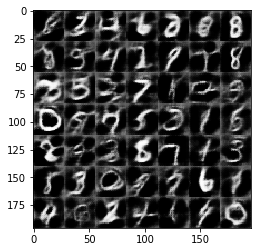

Epoch 2/2... Discriminator Loss: 1.0403... Generator Loss: 1.1084
Epoch 2/2... Discriminator Loss: 1.2744... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.7324... Generator Loss: 2.9451
Epoch 2/2... Discriminator Loss: 1.6561... Generator Loss: 0.4174
Epoch 2/2... Discriminator Loss: 1.1546... Generator Loss: 0.8127
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.8713


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 4.7606... Generator Loss: 108.9729
Epoch 1/2... Discriminator Loss: 32.4541... Generator Loss: 21.7952
Epoch 1/2... Discriminator Loss: 9.7285... Generator Loss: 32.9825
Epoch 1/2... Discriminator Loss: 19.0867... Generator Loss: 1.0397
Epoch 1/2... Discriminator Loss: 4.1501... Generator Loss: 2.5487
Epoch 1/2... Discriminator Loss: 1.7882... Generator Loss: 16.9887
Epoch 1/2... Discriminator Loss: 1.9510... Generator Loss: 4.0518
Epoch 1/2... Discriminator Loss: 1.2460... Generator Loss: 18.7259
Epoch 1/2... Discriminator Loss: 1.4168... Generator Loss: 8.5447
Epoch 1/2... Discriminator Loss: 0.6947... Generator Loss: 7.0782


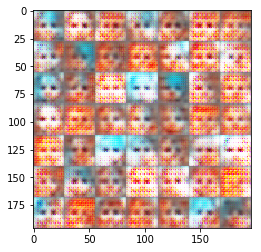

Epoch 1/2... Discriminator Loss: 0.7736... Generator Loss: 12.7896
Epoch 1/2... Discriminator Loss: 1.5432... Generator Loss: 15.5330
Epoch 1/2... Discriminator Loss: 1.8082... Generator Loss: 37.2793
Epoch 1/2... Discriminator Loss: 0.9889... Generator Loss: 9.0062
Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 2.3550
Epoch 1/2... Discriminator Loss: 0.5240... Generator Loss: 15.0343
Epoch 1/2... Discriminator Loss: 0.5843... Generator Loss: 2.8515
Epoch 1/2... Discriminator Loss: 0.5093... Generator Loss: 6.4079
Epoch 1/2... Discriminator Loss: 0.4463... Generator Loss: 14.6455
Epoch 1/2... Discriminator Loss: 1.7350... Generator Loss: 3.7090


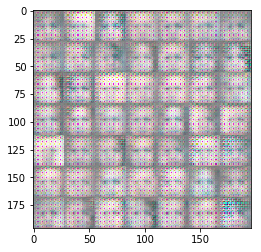

Epoch 1/2... Discriminator Loss: 0.5555... Generator Loss: 9.6640
Epoch 1/2... Discriminator Loss: 0.4479... Generator Loss: 6.9414
Epoch 1/2... Discriminator Loss: 1.8140... Generator Loss: 6.3169
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 1.2744
Epoch 1/2... Discriminator Loss: 0.9476... Generator Loss: 1.9255
Epoch 1/2... Discriminator Loss: 0.7340... Generator Loss: 1.4295
Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 0.8140
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 1.8186
Epoch 1/2... Discriminator Loss: 1.5695... Generator Loss: 3.6445
Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 1.7809


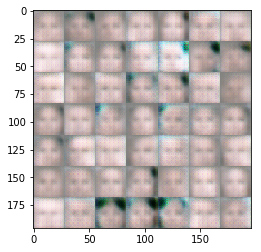

Epoch 1/2... Discriminator Loss: 3.2189... Generator Loss: 1.1857
Epoch 1/2... Discriminator Loss: 0.5649... Generator Loss: 2.7617
Epoch 1/2... Discriminator Loss: 0.7570... Generator Loss: 2.2298
Epoch 1/2... Discriminator Loss: 1.5781... Generator Loss: 2.1674
Epoch 1/2... Discriminator Loss: 2.4948... Generator Loss: 5.6863
Epoch 1/2... Discriminator Loss: 1.0901... Generator Loss: 0.8634
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 1.3120
Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 2.4186
Epoch 1/2... Discriminator Loss: 0.7503... Generator Loss: 1.4189
Epoch 1/2... Discriminator Loss: 1.7175... Generator Loss: 2.3909


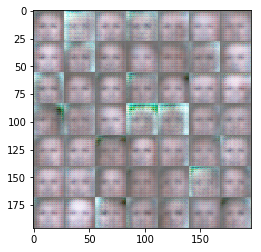

Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 1.6885
Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 1.3250
Epoch 1/2... Discriminator Loss: 2.5504... Generator Loss: 4.7084
Epoch 1/2... Discriminator Loss: 0.9007... Generator Loss: 1.1705
Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 1.9470
Epoch 1/2... Discriminator Loss: 0.7625... Generator Loss: 1.3265
Epoch 1/2... Discriminator Loss: 2.0716... Generator Loss: 0.2577
Epoch 1/2... Discriminator Loss: 0.6540... Generator Loss: 1.6939
Epoch 1/2... Discriminator Loss: 0.9794... Generator Loss: 1.0859
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 1.5252


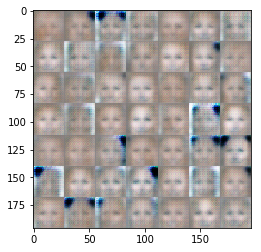

Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 1.1391
Epoch 1/2... Discriminator Loss: 1.1999... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.1392... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 0.4594... Generator Loss: 2.8962
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 0.5749
Epoch 1/2... Discriminator Loss: 0.7323... Generator Loss: 2.1240
Epoch 1/2... Discriminator Loss: 1.6004... Generator Loss: 2.0986
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 1.2179
Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 1.0273


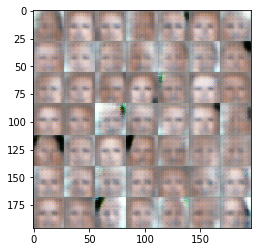

Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 1.1188
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 0.9755
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 1.4609
Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 1.1765
Epoch 1/2... Discriminator Loss: 1.0599... Generator Loss: 1.0105
Epoch 1/2... Discriminator Loss: 0.8642... Generator Loss: 1.7090
Epoch 1/2... Discriminator Loss: 0.8549... Generator Loss: 1.4364
Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 1.5788
Epoch 1/2... Discriminator Loss: 0.7242... Generator Loss: 1.3591
Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 1.6389


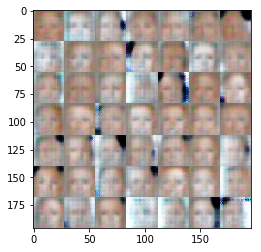

Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 1.2278
Epoch 1/2... Discriminator Loss: 2.6543... Generator Loss: 4.3360
Epoch 1/2... Discriminator Loss: 1.1992... Generator Loss: 1.1885
Epoch 1/2... Discriminator Loss: 0.5259... Generator Loss: 2.7794
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 0.8835
Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 3.0652
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 1.4570
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 0.7188
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 1.5942
Epoch 1/2... Discriminator Loss: 1.2309... Generator Loss: 2.8540


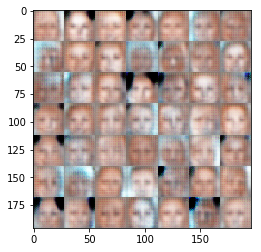

Epoch 1/2... Discriminator Loss: 1.5151... Generator Loss: 0.4705
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 1.1353
Epoch 1/2... Discriminator Loss: 0.8852... Generator Loss: 1.4168
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 0.8147
Epoch 1/2... Discriminator Loss: 3.1657... Generator Loss: 3.9363
Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 1.3041
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 0.8767
Epoch 1/2... Discriminator Loss: 1.0498... Generator Loss: 0.9674
Epoch 1/2... Discriminator Loss: 0.5449... Generator Loss: 2.0560
Epoch 1/2... Discriminator Loss: 1.6277... Generator Loss: 0.4375


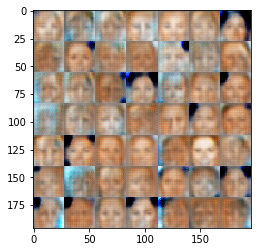

Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 1.0441
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 1.2168
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 1.2112
Epoch 1/2... Discriminator Loss: 1.1763... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 2.5572
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 1.6872
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 1.0074
Epoch 1/2... Discriminator Loss: 1.3684... Generator Loss: 2.4433
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 1.1722
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.7110


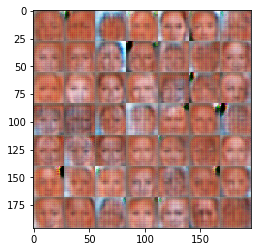

Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 1.2509
Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 1.1442
Epoch 1/2... Discriminator Loss: 1.2007... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 0.9578
Epoch 1/2... Discriminator Loss: 1.3063... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 2.0910... Generator Loss: 0.3148
Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 0.4506
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 2.0642
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.7900


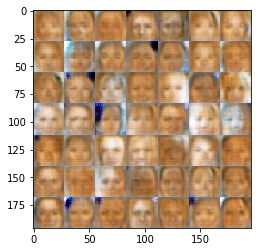

Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 1.1658
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 1.4229
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.8881
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 0.9648
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.1903
Epoch 1/2... Discriminator Loss: 1.2137... Generator Loss: 1.5960
Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 1.6707
Epoch 1/2... Discriminator Loss: 1.0152... Generator Loss: 0.8591
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 0.9584


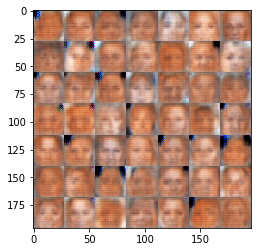

Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.9335
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 1.1210
Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 0.5009
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 0.9710
Epoch 1/2... Discriminator Loss: 1.0453... Generator Loss: 1.0038
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 1.3017
Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 1.1827
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 1.5264


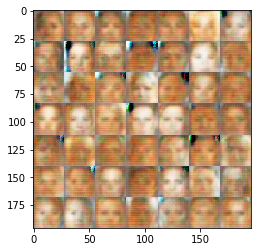

Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 1.1399
Epoch 1/2... Discriminator Loss: 0.6879... Generator Loss: 1.6170
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 0.9477
Epoch 1/2... Discriminator Loss: 0.9492... Generator Loss: 1.0467
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.8444
Epoch 1/2... Discriminator Loss: 0.8610... Generator Loss: 2.2985
Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 2.3226
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 1.0842


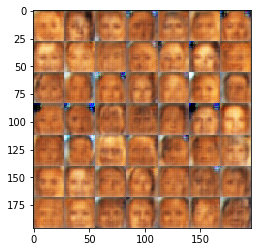

Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 1.2749
Epoch 1/2... Discriminator Loss: 0.9746... Generator Loss: 1.1991
Epoch 1/2... Discriminator Loss: 0.9114... Generator Loss: 1.5104
Epoch 1/2... Discriminator Loss: 1.2094... Generator Loss: 1.4737
Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 1.4307
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 1.1261
Epoch 1/2... Discriminator Loss: 1.0710... Generator Loss: 1.2224
Epoch 1/2... Discriminator Loss: 1.0578... Generator Loss: 1.3273
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.7289
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 1.1549


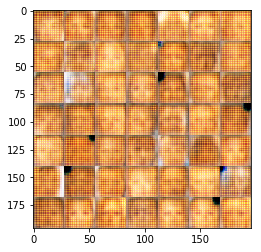

Epoch 1/2... Discriminator Loss: 1.7077... Generator Loss: 0.4134
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 0.9860
Epoch 1/2... Discriminator Loss: 1.2968... Generator Loss: 0.9495
Epoch 1/2... Discriminator Loss: 1.2245... Generator Loss: 0.9497
Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.7166
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 0.9746... Generator Loss: 1.0450
Epoch 1/2... Discriminator Loss: 1.9652... Generator Loss: 0.2667
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 1.0104
Epoch 1/2... Discriminator Loss: 1.4655... Generator Loss: 0.4836


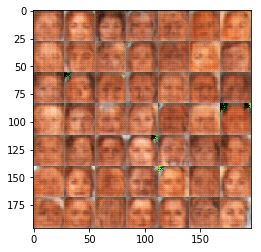

Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 1.1072
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 1.3056
Epoch 1/2... Discriminator Loss: 1.1223... Generator Loss: 0.8994
Epoch 1/2... Discriminator Loss: 1.1308... Generator Loss: 1.0518
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.4802... Generator Loss: 0.4705
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 0.8338
Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 1.3572
Epoch 1/2... Discriminator Loss: 0.8696... Generator Loss: 1.6598


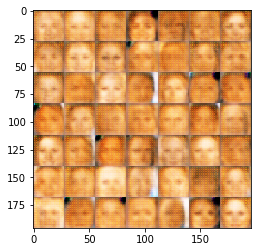

Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 1.1421
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 1.2858
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 1.0248
Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 1.1164
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.1311
Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 1.3848
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 1.0344
Epoch 1/2... Discriminator Loss: 1.5232... Generator Loss: 1.0538
Epoch 1/2... Discriminator Loss: 1.3170... Generator Loss: 0.8152


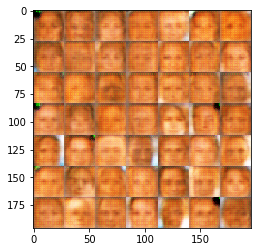

Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 0.8979
Epoch 1/2... Discriminator Loss: 1.2253... Generator Loss: 0.9154
Epoch 1/2... Discriminator Loss: 2.6417... Generator Loss: 0.2225
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 1.1869
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 1.0947
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 1.3060
Epoch 1/2... Discriminator Loss: 0.9520... Generator Loss: 1.3079
Epoch 1/2... Discriminator Loss: 2.5572... Generator Loss: 0.1519
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.8647
Epoch 1/2... Discriminator Loss: 1.4988... Generator Loss: 1.2830


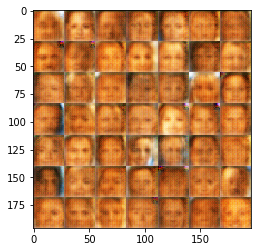

Epoch 1/2... Discriminator Loss: 1.0648... Generator Loss: 1.1741
Epoch 1/2... Discriminator Loss: 2.7633... Generator Loss: 3.5299
Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 1.0906
Epoch 1/2... Discriminator Loss: 0.8929... Generator Loss: 1.2866
Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 2.3218
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 1.8060
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 2.1907
Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 1.1214
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 1.1108
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 2.7005


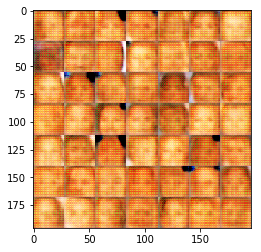

Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 2.0259
Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 1.4004... Generator Loss: 2.4490
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.8910
Epoch 1/2... Discriminator Loss: 1.2611... Generator Loss: 1.0505
Epoch 1/2... Discriminator Loss: 0.9436... Generator Loss: 1.0159
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.7478
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 1.0774
Epoch 1/2... Discriminator Loss: 1.2010... Generator Loss: 1.1419
Epoch 1/2... Discriminator Loss: 1.6214... Generator Loss: 0.3833


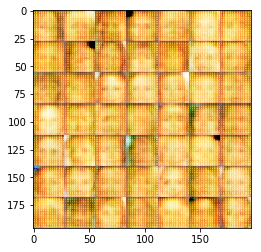

Epoch 1/2... Discriminator Loss: 1.0907... Generator Loss: 1.3155
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.9352
Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 1.5380
Epoch 1/2... Discriminator Loss: 2.1335... Generator Loss: 2.7156
Epoch 1/2... Discriminator Loss: 1.3356... Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 1.0442... Generator Loss: 0.8264
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.3414
Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 1.0375
Epoch 2/2... Discriminator Loss: 1.3217... Generator Loss: 0.6425
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 1.0922


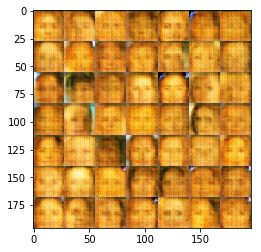

Epoch 2/2... Discriminator Loss: 1.6311... Generator Loss: 2.3464
Epoch 2/2... Discriminator Loss: 0.6542... Generator Loss: 1.8552
Epoch 2/2... Discriminator Loss: 0.8240... Generator Loss: 1.2525
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 1.6205
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 1.4653
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.1895
Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 2.3462
Epoch 2/2... Discriminator Loss: 1.0156... Generator Loss: 0.9241
Epoch 2/2... Discriminator Loss: 1.2422... Generator Loss: 1.3472
Epoch 2/2... Discriminator Loss: 1.2843... Generator Loss: 0.9865


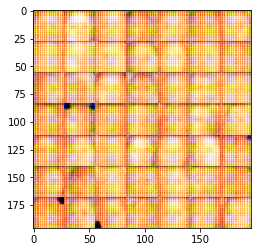

Epoch 2/2... Discriminator Loss: 1.1602... Generator Loss: 1.0505
Epoch 2/2... Discriminator Loss: 1.4709... Generator Loss: 0.5836
Epoch 2/2... Discriminator Loss: 1.5160... Generator Loss: 0.6943
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 1.1093
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 1.5742... Generator Loss: 0.5120
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.9319
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 0.9576
Epoch 2/2... Discriminator Loss: 1.0625... Generator Loss: 1.0955


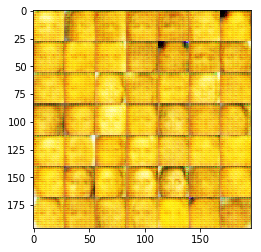

Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 1.0183
Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 0.9572
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 0.8593
Epoch 2/2... Discriminator Loss: 1.7504... Generator Loss: 0.3675
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 0.8851
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 1.3962
Epoch 2/2... Discriminator Loss: 1.4587... Generator Loss: 0.4921
Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 1.5329... Generator Loss: 2.0783
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.7807


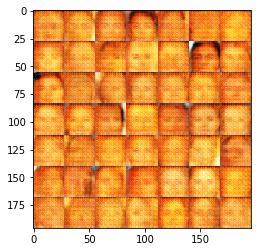

Epoch 2/2... Discriminator Loss: 1.2210... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 2.9878... Generator Loss: 0.1023
Epoch 2/2... Discriminator Loss: 1.2872... Generator Loss: 0.9536
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.9360
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 1.3481
Epoch 2/2... Discriminator Loss: 1.0414... Generator Loss: 1.2985
Epoch 2/2... Discriminator Loss: 1.0309... Generator Loss: 1.0331
Epoch 2/2... Discriminator Loss: 1.2739... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 1.4084
Epoch 2/2... Discriminator Loss: 1.2422... Generator Loss: 1.3397


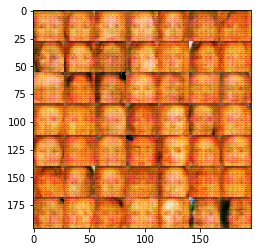

Epoch 2/2... Discriminator Loss: 1.4652... Generator Loss: 2.2877
Epoch 2/2... Discriminator Loss: 1.1675... Generator Loss: 1.2402
Epoch 2/2... Discriminator Loss: 1.6252... Generator Loss: 0.4196
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 1.1720
Epoch 2/2... Discriminator Loss: 1.7699... Generator Loss: 1.9999
Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 1.2823
Epoch 2/2... Discriminator Loss: 1.1338... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 1.1086
Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 1.1703
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 1.2104


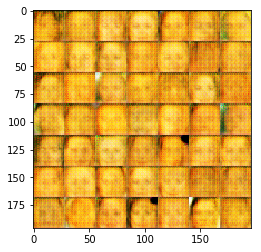

Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.8832
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.8752
Epoch 2/2... Discriminator Loss: 1.1408... Generator Loss: 1.4327
Epoch 2/2... Discriminator Loss: 1.1161... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 1.2207
Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 1.1232
Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 1.4051
Epoch 2/2... Discriminator Loss: 1.2681... Generator Loss: 0.8093


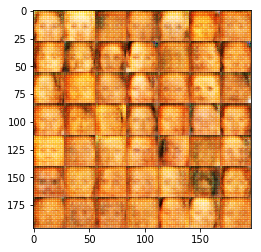

Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 1.1362
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.9096
Epoch 2/2... Discriminator Loss: 1.4436... Generator Loss: 1.0947
Epoch 2/2... Discriminator Loss: 1.2040... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 1.2774... Generator Loss: 0.9002
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 1.3017
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 1.4771
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 2.0587
Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 1.2844


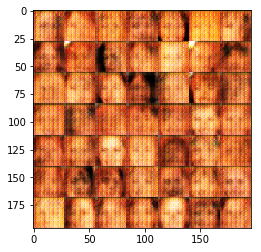

Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 1.0799
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.8085
Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 2.0776
Epoch 2/2... Discriminator Loss: 1.5812... Generator Loss: 0.6245
Epoch 2/2... Discriminator Loss: 1.4925... Generator Loss: 3.0059
Epoch 2/2... Discriminator Loss: 1.2441... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 0.8692... Generator Loss: 2.1539
Epoch 2/2... Discriminator Loss: 1.1573... Generator Loss: 1.1082
Epoch 2/2... Discriminator Loss: 1.4654... Generator Loss: 0.5588
Epoch 2/2... Discriminator Loss: 1.1578... Generator Loss: 1.0960


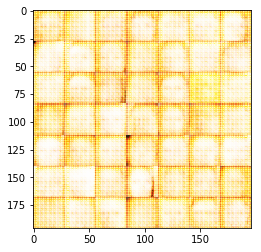

Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 1.1193
Epoch 2/2... Discriminator Loss: 1.4083... Generator Loss: 0.6612
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 1.1042
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 1.3116... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 1.7660... Generator Loss: 2.0529
Epoch 2/2... Discriminator Loss: 1.1664... Generator Loss: 0.9817
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 0.8319
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 1.6087


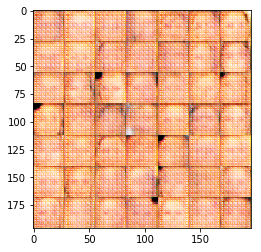

Epoch 2/2... Discriminator Loss: 1.2042... Generator Loss: 0.9300
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 1.0945
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.9334
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 1.6839
Epoch 2/2... Discriminator Loss: 1.6280... Generator Loss: 0.4459
Epoch 2/2... Discriminator Loss: 1.1902... Generator Loss: 1.0179
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 1.0770... Generator Loss: 0.9743
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 1.0323
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 1.0069


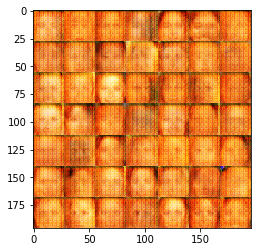

Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.5353
Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 1.0262
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 1.4432... Generator Loss: 0.5130
Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 0.9769
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.5298
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.9077
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 1.4650
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 0.8133


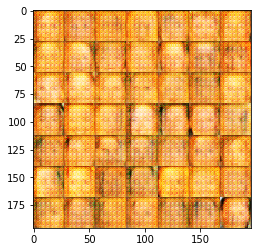

Epoch 2/2... Discriminator Loss: 0.5646... Generator Loss: 2.4616
Epoch 2/2... Discriminator Loss: 0.7458... Generator Loss: 1.6840
Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 0.9787
Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 1.0035
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.1953... Generator Loss: 1.0696
Epoch 2/2... Discriminator Loss: 1.1793... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 1.0049... Generator Loss: 1.2287


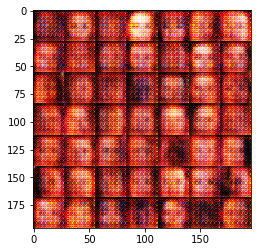

Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 0.9504
Epoch 2/2... Discriminator Loss: 1.9565... Generator Loss: 3.2377
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 1.4717
Epoch 2/2... Discriminator Loss: 0.9966... Generator Loss: 1.2171
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 0.8518... Generator Loss: 1.1095
Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 0.7092
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 1.1762
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.1755
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 1.0679


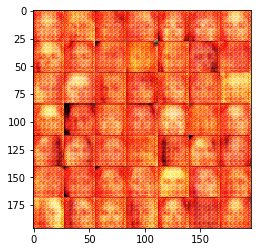

Epoch 2/2... Discriminator Loss: 2.2431... Generator Loss: 2.9514
Epoch 2/2... Discriminator Loss: 1.1621... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.2393... Generator Loss: 0.6987
Epoch 2/2... Discriminator Loss: 1.4530... Generator Loss: 0.7123
Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 1.3253
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 1.3906
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 1.7787
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.7051
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 1.1986
Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 1.0682


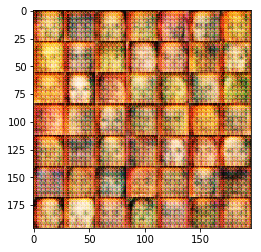

Epoch 2/2... Discriminator Loss: 1.4085... Generator Loss: 0.5611
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 1.3133
Epoch 2/2... Discriminator Loss: 1.4806... Generator Loss: 0.4843
Epoch 2/2... Discriminator Loss: 1.1691... Generator Loss: 1.5584
Epoch 2/2... Discriminator Loss: 1.3287... Generator Loss: 0.5880
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 1.1523
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 1.0520
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 1.4120
Epoch 2/2... Discriminator Loss: 1.2601... Generator Loss: 0.7328


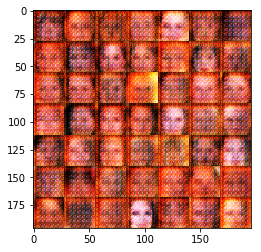

Epoch 2/2... Discriminator Loss: 1.5163... Generator Loss: 0.5056
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.1080
Epoch 2/2... Discriminator Loss: 1.2590... Generator Loss: 0.7014
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.6018
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 0.8140
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 0.7526
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 1.3596
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 1.5001... Generator Loss: 1.4547
Epoch 2/2... Discriminator Loss: 1.2696... Generator Loss: 0.7814


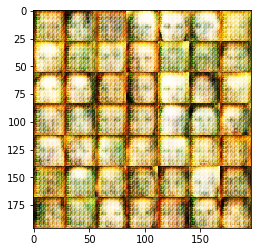

Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 0.8512
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 1.0461
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.8655
Epoch 2/2... Discriminator Loss: 1.3046... Generator Loss: 1.2434
Epoch 2/2... Discriminator Loss: 1.2470... Generator Loss: 0.6540
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 0.6159
Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 0.8306
Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 1.1467
Epoch 2/2... Discriminator Loss: 1.1525... Generator Loss: 1.2559
Epoch 2/2... Discriminator Loss: 1.1232... Generator Loss: 0.9356


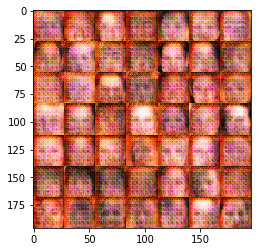

Epoch 2/2... Discriminator Loss: 1.1975... Generator Loss: 0.8047
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 1.2431
Epoch 2/2... Discriminator Loss: 1.3351... Generator Loss: 0.6647
Epoch 2/2... Discriminator Loss: 1.3942... Generator Loss: 2.0817
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 1.0468
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 1.1386... Generator Loss: 1.2676
Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 1.0859
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 1.0456


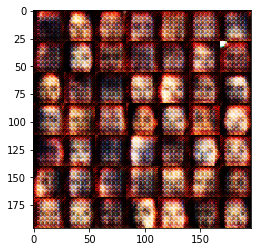

Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 0.9032
Epoch 2/2... Discriminator Loss: 0.8785... Generator Loss: 1.6785
Epoch 2/2... Discriminator Loss: 0.7515... Generator Loss: 2.1865
Epoch 2/2... Discriminator Loss: 1.1281... Generator Loss: 1.0180
Epoch 2/2... Discriminator Loss: 1.0022... Generator Loss: 1.7596
Epoch 2/2... Discriminator Loss: 1.7245... Generator Loss: 3.3660
Epoch 2/2... Discriminator Loss: 1.1618... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 1.3514... Generator Loss: 0.7816
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.5503


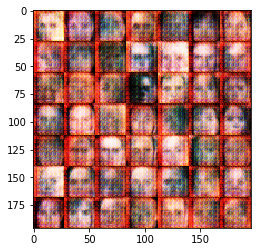

Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 1.5635
Epoch 2/2... Discriminator Loss: 1.1221... Generator Loss: 1.1263
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 2.3829
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 0.7532
Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 1.4538
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 1.3386
Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 1.6801
Epoch 2/2... Discriminator Loss: 1.6019... Generator Loss: 0.5337
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 1.4067


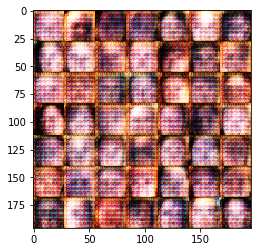

Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.5462
Epoch 2/2... Discriminator Loss: 1.0402... Generator Loss: 0.8906
Epoch 2/2... Discriminator Loss: 1.1670... Generator Loss: 1.0463
Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 1.0236
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 1.5510... Generator Loss: 0.5167
Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.9454
Epoch 2/2... Discriminator Loss: 1.1204... Generator Loss: 1.1447


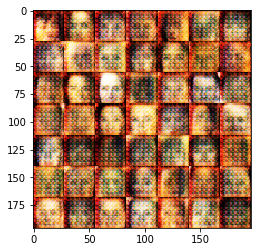

Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 1.0756
Epoch 2/2... Discriminator Loss: 1.6555... Generator Loss: 2.0093
Epoch 2/2... Discriminator Loss: 1.1709... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 1.1416
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 1.3421
Epoch 2/2... Discriminator Loss: 1.4283... Generator Loss: 0.5676


In [90]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.6

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.